In [1]:
import numpy as np
from smrt.synthetic import CvMTGM_ID_Model

# Visible dimensions
n_visible = 2

# Space size
x_min = -1
x_max = 1
y_min = -1
y_max = 1

# Total number of targets to create
n_targets = 12

# Total Steps to simulate
n_steps = 100

# Define target birth locations and randomized velocity
n_birth_locations = 4

# Maximum birth velocity
birth_velocity_max = 0.01

# Target lifespan max min
lifespan_max = 100
lifespan_min = 20

# STD of CV disturbance on state updates
v_cov_std = 0.002

# STD of disturbance on measurements
r_cov_std = 0.01

# Detection Probability
p_d = 0.9

# Average number of false positive measurements to generate each time step
clutter_lam = 4

# Uniform distribution of generated false positives
clutter_c = 1/(2*2)

# Spatial sampling function for false positive measurement generation
def clutter_sample_fn():
  return np.random.uniform(-1, 1, size=(2,))

In [2]:
# Generate birth array of each target
birth = np.round(np.random.uniform(0, n_steps - lifespan_min, size=(n_targets,))).astype(np.int)
birth.sort()
birth[0] = 0
print('Synthetic target birth:', birth)

Synthetic target birth: [ 0 15 35 58 58 60 62 65 66 69 72 77]


In [3]:
# Generate target death
# - First, we generate the lifespan of each target
lifespan = np.round(np.random.uniform(lifespan_min, lifespan_max, size=(n_targets,))).astype(np.int)
death = birth + lifespan
death = np.clip(death, 0, n_steps)
print('Synthetic target death:', death)

Synthetic target death: [ 28  46  84 100  94 100 100 100 100 100 100 100]


In [4]:
# Generate target birth location
possible_birth_locations = np.block([
  np.random.uniform(x_min, x_max, size=(n_birth_locations, 1)),
  np.random.uniform(y_min, y_max, size=(n_birth_locations, 1))  
])
x_init = np.block([
  possible_birth_locations[
    np.random.randint(n_birth_locations, size=(n_targets,)), :
  ],
  np.random.uniform(-birth_velocity_max, birth_velocity_max, size=(n_targets, 2))
])

with np.printoptions(precision=3, suppress=True):
  print('Target birth state:\n', x_init)

Target birth state:
 [[ 0.226  0.396 -0.008  0.008]
 [ 0.271 -0.834 -0.    -0.005]
 [ 0.419  0.603 -0.009 -0.001]
 [ 0.419  0.603 -0.006 -0.006]
 [ 0.419  0.603  0.004 -0.007]
 [ 0.226  0.396  0.003  0.01 ]
 [ 0.226  0.396 -0.006 -0.008]
 [ 0.419  0.603  0.004  0.   ]
 [ 0.271 -0.834  0.002  0.005]
 [ 0.271 -0.834  0.004 -0.006]
 [ 0.271 -0.834  0.001 -0.01 ]
 [ 0.226  0.396  0.006 -0.005]]


In [5]:
%matplotlib inline
from IPython.display import HTML
from matplotlib import animation, rc
from smrt.visualizer.gmphd import animate2d_prediction

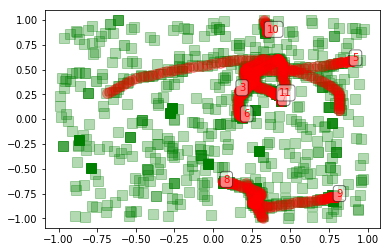

In [6]:
# Generate synthetic data
model = CvMTGM_ID_Model(
    n_visible=n_visible,
    v_stddev=v_cov_std,
    m_stddev=r_cov_std,
    birth=(np.zeros((0,)), np.zeros((0,4)), np.zeros((0, 4, 4))),
    p_d=p_d,
    p_s=1.,
    clutter_lam=clutter_lam,
    clutter_c=clutter_c
)

truth, observations = model.generate_synthetic_data(
    target_birth_steps=birth,
    target_birth_locations=x_init,
    target_death_steps=death,
    simulation_length=n_steps,
    clutter_spatial_sample_fn=clutter_sample_fn,
    bounds=np.array([[-1, 1], [-1, 1]])
)

anim = animate2d_prediction(observation=observations, truth=truth)
HTML(anim.to_html5_video())

In [7]:
import os

chkpt_filename = os.path.join('synthetic_2d.npz')

In [8]:
# Save to file
data = {
  'truth': truth,
  'observations': observations,
  'x_min': x_min,
  'y_min': y_min,
  'x_max': x_max,
  'y_max': y_max,
  'n_visible': n_visible,
  'n_targets': n_targets,
  'n_steps': n_steps,
  'n_birth_locations': n_birth_locations,
  'v_cov_std': v_cov_std,
  'r_cov_std': r_cov_std,
  'p_d': p_d,
  'clutter_lam': clutter_lam,
  'clutter_c': clutter_c,
  'birth': birth,
  'death': death,
  'possible_birth_locations': possible_birth_locations,
  'x_init': x_init
}
np.savez(chkpt_filename, **data)

In [9]:
# Load from file
data = np.load(chkpt_filename)
# Note: Truth is a dictionary, thus we need .item()
truth = data['truth'].item()
observations = data['observations']

## Choice of parameters Vs. Performance

If we inherit all the parameters from synthetic data, we want to see how the choice of additional parameters of GM-PHD filter impacts the performance of the filter.

Those additional parameters include birth_weights, covariance matrix of Gaussian components in the birth PHD, and the target survival rate. For the speed of test, we limit the maximum Gaussian components in each Gaussian mixture to 100.

In [10]:
# This is the birth PHD, which is not used in synthetic data generation.
# As a result, the settings here may have some performance impact
birth_weights = np.zeros((n_birth_locations,), dtype=np.float)
birth_weights[:] = 0.03

birth_means = np.block([
  possible_birth_locations[:, :n_visible],
  np.zeros((n_birth_locations, 2))
])

birth_std = 0.01

birth_covs = np.array([
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std
], dtype=np.float)

# Target survival rate
p_s = 0.9

# Maximum number of Gaussian components to keep
Jmax = 100

In [11]:
def target_state_estimation(gm_weights, gm_means):
  track_indexes = {}
  n_gc = gm_weights.shape[0]
  # Group Gaussian components in each track
  for i in range(n_gc):
    track_id = int(round(gm_means[i, -1]))
    if track_id in track_indexes:
      track_indexes[track_id].append(i)
    else:
      track_indexes[track_id] = [i]
  # Estimate state of each target
  n_tracks = len(track_indexes)
  track_states = np.zeros((n_tracks, 5), dtype=np.float)
  track_weights = np.zeros((n_tracks), dtype=np.float)
  for j, track_id in enumerate(track_indexes):
    track_state = np.zeros((5,), dtype=np.float)
    track_weight = 0.
    for i in track_indexes[track_id]:
      track_weight += gm_weights[i]
      track_state += gm_weights[i] * gm_means[i, :]
    track_weights[j] = track_weight
    track_states[j, :] = track_state / track_weight
  return track_states, track_weights

In [37]:
import matplotlib.pyplot as plt

def plot_clear_metrics(x_values, mota_reports, x_label, x_logscale=False):
  figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
  metrics = ['mrta', 'misses', 'false positives', 'mismatches']

  axes_dict = {
    'mrta': axes[0][0],
    'misses': axes[0][1],
    'false positives': axes[1][0],
    'mismatches': axes[1][1]
  }
  
  plot_data = {
    'mrta': [
      1 - (report['miss'] + report['fp'] + report['mismatch']) / report['total']
      for report in mota_reports
    ],
    'false positives': [
      report['fp'] / report['total']
      for report in mota_reports
    ],
    'misses': [
      report['miss'] / report['total']
      for report in mota_reports
    ],
    'mismatches': [
      report['mismatch'] / report['total']
      for report in mota_reports
    ]
  }
  
  for metric in metrics:
    ax = axes_dict[metric]
    ax.plot(
      x_values, plot_data[metric]
    )
    ax.set_ylabel(metric)
    ax.set_xlabel(x_label)
    if x_logscale:
      ax.set_xscale('log')
  figure.tight_layout()
  return figure

### Survival Rate Vs. Performance

In [12]:
import os
from tensorflow.python.keras.utils.generic_utils import Progbar
from smrt.metrics import clear_metrics

In [27]:
# Save the result to p_s_experiments folder
ps_chkpt_dir = './p_s_experiments'
os.makedirs(ps_chkpt_dir, exist_ok=True)

# To reduce the log size, keep maximum number of Gaussian components to 50
Jmax = 30

survival_rates = np.arange(0.6, 1.05, 0.05)
mota_scores = []
mota_reports = []

for p_s in survival_rates:
  model = CvMTGM_ID_Model(
    n_visible=n_visible,
    v_stddev=v_cov_std,
    m_stddev=r_cov_std,
    birth=(birth_weights, birth_means, birth_covs),
    p_d=p_d,
    p_s=p_s,
    clutter_lam=clutter_lam,
    clutter_c=clutter_c
  )

  # Initial weights, means and covariance of Gaussian mixture
  gm_weights = np.zeros((0,))
  gm_means = np.zeros((0, 4))
  gm_covs = np.zeros((0, 4, 4))

  # Records
  gm_phds = []
  prediction = {
    'locations': [],
    'targets': []
  }

  # Start running the GM-PHD filter based on the observations
  n_obs = len(observations)
  # Progress bar
  progbar = Progbar(
    target=n_obs,
    verbose=1,
    stateful_metrics=['tracks', 'cardinality'],
    unit_name='step'
  )
  valid_tracks = set()
  for k in range(n_obs):
    # Call the filter process
    gm_weights, gm_means, gm_covs = model.call((gm_weights, gm_means, gm_covs, observations[k]))
    # Only keep the top few Gaussian components
    gm_weights, gm_means, gm_covs = model.gm_truncate(gm_weights, gm_means, gm_covs, Jmax)
    # Clutter GMs
    gm_weights, gm_means, gm_covs = model.gm_id_cluster(gm_weights, gm_means, gm_covs)
    # Save GM_PHDs
    gm_phds.append((np.copy(gm_weights), np.copy(gm_means), np.copy(gm_covs)))
    # Form track information
    track_states, track_weights = target_state_estimation(gm_weights, gm_means)
    # Form prediction
    num_tracks = track_states.shape[0]
    valid_track_ind = []
    for t_id in range(num_tracks):
      track_id = int(round(track_states[t_id, -1]))
      if track_id != 0 and track_weights[t_id] >= 0.5:
        valid_tracks.add(track_id)
      if track_id in valid_tracks:
        valid_track_ind.append(t_id)
    track_locations = np.zeros((len(valid_track_ind), 5), dtype=np.float)
    track_targets = np.zeros((len(valid_track_ind),), dtype=np.int)
    for i, t_id in enumerate(valid_track_ind):
      track_id = int(round(track_states[t_id, -1]))
      track_locations[i, :] = track_states[t_id, :]
      track_targets[i] = track_id
    prediction['locations'].append(track_locations)
    prediction['targets'].append(track_targets)
    progbar.update(k+1, [
      ('tracks', track_targets.shape[0]),
      ('cardinality', np.sum(track_weights))
    ])
  
  # Save results
  data = {
    'gm_phds': gm_phds,
    'prediction': prediction
  }
  chkpt_filename = 'result_ps_0_%2d.npz' % int(p_s * 100)
  np.savez(chkpt_filename, **data) 
  
  # Save the result
  associations = clear_metrics.mot_hypothesis_association(truth, prediction, ndims=2, threshold=0.2)
  mota_report = clear_metrics.mota_report(associations)
  mota_score = clear_metrics.mota_score(associations)
  mota_reports.append(mota_report)
  mota_scores.append(mota_score)


100/100 [==============================] - 0s 20us/step - total: 419.0000 - correct: 298.0000 - miss: 84.0000 - fp: 41.0000 - mismatch: 37.0000


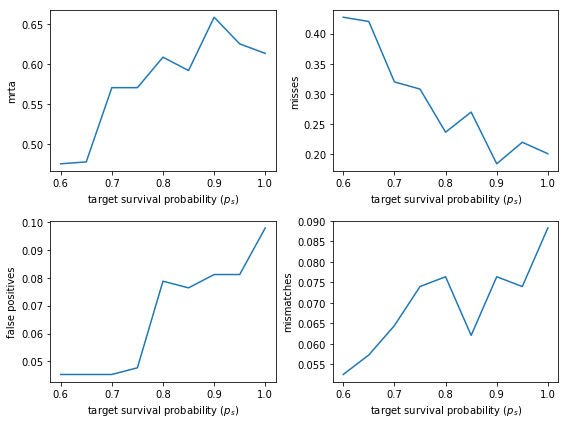

In [28]:
fig = plot_clear_metrics(survival_rates, mota_reports, 'target survival probability ($p_s$)')

## Birth Weights Vs. Performance

In [32]:
# Reset

# This is the birth PHD, which is not used in synthetic data generation.
# As a result, the settings here may have some performance impact
birth_weights = np.zeros((n_birth_locations,), dtype=np.float)
birth_weights[:] = 0.03

birth_means = np.block([
  possible_birth_locations[:, :n_visible],
  np.zeros((n_birth_locations, 2))
])

birth_std = 0.01

birth_covs = np.array([
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std
], dtype=np.float)

# Target survival rate
p_s = 0.9

# Maximum number of Gaussian components to keep
Jmax = 100

In [33]:
# Save the result to p_s_experiments folder
ps_chkpt_dir = './birth_weight_experiments'
os.makedirs(ps_chkpt_dir, exist_ok=True)

# To reduce the log size, keep maximum number of Gaussian components to 50
Jmax = 30

birth_weight_list = np.arange(0.1, 0.55, 0.05)
mota_scores = []
mota_reports = []

for bw in birth_weight_list:
  birth_weights[:] = bw
  model = CvMTGM_ID_Model(
    n_visible=n_visible,
    v_stddev=v_cov_std,
    m_stddev=r_cov_std,
    birth=(birth_weights, birth_means, birth_covs),
    p_d=p_d,
    p_s=p_s,
    clutter_lam=clutter_lam,
    clutter_c=clutter_c
  )

  # Initial weights, means and covariance of Gaussian mixture
  gm_weights = np.zeros((0,))
  gm_means = np.zeros((0, 4))
  gm_covs = np.zeros((0, 4, 4))

  # Records
  gm_phds = []
  prediction = {
    'locations': [],
    'targets': []
  }

  # Start running the GM-PHD filter based on the observations
  n_obs = len(observations)
  # Progress bar
  progbar = Progbar(
    target=n_obs,
    verbose=1,
    stateful_metrics=['tracks', 'cardinality'],
    unit_name='step'
  )
  valid_tracks = set()
  for k in range(n_obs):
    # Call the filter process
    gm_weights, gm_means, gm_covs = model.call((gm_weights, gm_means, gm_covs, observations[k]))
    # Only keep the top few Gaussian components
    gm_weights, gm_means, gm_covs = model.gm_truncate(gm_weights, gm_means, gm_covs, Jmax)
    # Clutter GMs
    gm_weights, gm_means, gm_covs = model.gm_id_cluster(gm_weights, gm_means, gm_covs)
    # Save GM_PHDs
    gm_phds.append((np.copy(gm_weights), np.copy(gm_means), np.copy(gm_covs)))
    # Form track information
    track_states, track_weights = target_state_estimation(gm_weights, gm_means)
    # Form prediction
    num_tracks = track_states.shape[0]
    valid_track_ind = []
    for t_id in range(num_tracks):
      track_id = int(round(track_states[t_id, -1]))
      if track_id != 0 and track_weights[t_id] >= 0.5:
        valid_tracks.add(track_id)
      if track_id in valid_tracks:
        valid_track_ind.append(t_id)
    track_locations = np.zeros((len(valid_track_ind), 5), dtype=np.float)
    track_targets = np.zeros((len(valid_track_ind),), dtype=np.int)
    for i, t_id in enumerate(valid_track_ind):
      track_id = int(round(track_states[t_id, -1]))
      track_locations[i, :] = track_states[t_id, :]
      track_targets[i] = track_id
    prediction['locations'].append(track_locations)
    prediction['targets'].append(track_targets)
    progbar.update(k+1, [
      ('tracks', track_targets.shape[0]),
      ('cardinality', np.sum(track_weights))
    ])
  
  # Save results
  data = {
    'gm_phds': gm_phds,
    'prediction': prediction
  }
  chkpt_filename = 'result_ps_0_%2d.npz' % int(p_s * 100)
  np.savez(chkpt_filename, **data) 
  
  # Save the result
  associations = clear_metrics.mot_hypothesis_association(truth, prediction, ndims=2, threshold=0.2)
  mota_report = clear_metrics.mota_report(associations)
  mota_score = clear_metrics.mota_score(associations)
  mota_reports.append(mota_report)
  mota_scores.append(mota_score)


100/100 [==============================] - 0s 30us/step - total: 419.0000 - correct: 292.0000 - miss: 60.0000 - fp: 189.0000 - mismatch: 67.0000


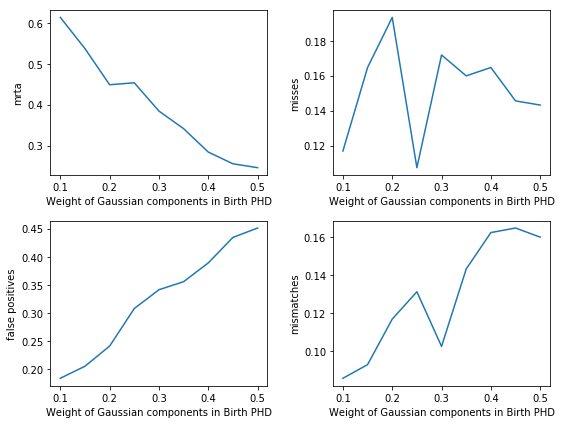

In [34]:
fig = plot_clear_metrics(birth_weight_list, mota_reports, 'Weight of Gaussian components in Birth PHD')

### Birth Covs Vs Performance

In [47]:
# Reset

# This is the birth PHD, which is not used in synthetic data generation.
# As a result, the settings here may have some performance impact
birth_weights = np.zeros((n_birth_locations,), dtype=np.float)
birth_weights[:] = 0.03

birth_means = np.block([
  possible_birth_locations[:, :n_visible],
  np.zeros((n_birth_locations, 2))
])

birth_std = 0.01

birth_covs = np.array([
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std,
  np.eye(4) * birth_std * birth_std
], dtype=np.float)

# Target survival rate
p_s = 0.9

# Maximum number of Gaussian components to keep
Jmax = 100

In [48]:
# Save the result to p_s_experiments folder
ps_chkpt_dir = './birth_covs_experiments'
os.makedirs(ps_chkpt_dir, exist_ok=True)

# To reduce the log size, keep maximum number of Gaussian components to 50
Jmax = 30

birth_std_list = np.linspace(0.001, 0.2, 30)
mota_scores = []
mota_reports = []

for birth_std in birth_std_list:
  birth_covs = np.array([
    np.eye(4) * birth_std * birth_std,
    np.eye(4) * birth_std * birth_std,
    np.eye(4) * birth_std * birth_std,
    np.eye(4) * birth_std * birth_std
  ], dtype=np.float)
  model = CvMTGM_ID_Model(
    n_visible=n_visible,
    v_stddev=v_cov_std,
    m_stddev=r_cov_std,
    birth=(birth_weights, birth_means, birth_covs),
    p_d=p_d,
    p_s=p_s,
    clutter_lam=clutter_lam,
    clutter_c=clutter_c
  )

  # Initial weights, means and covariance of Gaussian mixture
  gm_weights = np.zeros((0,))
  gm_means = np.zeros((0, 4))
  gm_covs = np.zeros((0, 4, 4))

  # Records
  gm_phds = []
  prediction = {
    'locations': [],
    'targets': []
  }

  # Start running the GM-PHD filter based on the observations
  n_obs = len(observations)
  # Progress bar
  progbar = Progbar(
    target=n_obs,
    verbose=1,
    stateful_metrics=['tracks', 'cardinality'],
    unit_name='step'
  )
  valid_tracks = set()
  for k in range(n_obs):
    # Call the filter process
    gm_weights, gm_means, gm_covs = model.call((gm_weights, gm_means, gm_covs, observations[k]))
    # Only keep the top few Gaussian components
    gm_weights, gm_means, gm_covs = model.gm_truncate(gm_weights, gm_means, gm_covs, Jmax)
    # Clutter GMs
    gm_weights, gm_means, gm_covs = model.gm_id_cluster(gm_weights, gm_means, gm_covs)
    # Save GM_PHDs
    gm_phds.append((np.copy(gm_weights), np.copy(gm_means), np.copy(gm_covs)))
    # Form track information
    track_states, track_weights = target_state_estimation(gm_weights, gm_means)
    # Form prediction
    num_tracks = track_states.shape[0]
    valid_track_ind = []
    for t_id in range(num_tracks):
      track_id = int(round(track_states[t_id, -1]))
      if track_id != 0 and track_weights[t_id] >= 0.5:
        valid_tracks.add(track_id)
      if track_id in valid_tracks:
        valid_track_ind.append(t_id)
    track_locations = np.zeros((len(valid_track_ind), 5), dtype=np.float)
    track_targets = np.zeros((len(valid_track_ind),), dtype=np.int)
    for i, t_id in enumerate(valid_track_ind):
      track_id = int(round(track_states[t_id, -1]))
      track_locations[i, :] = track_states[t_id, :]
      track_targets[i] = track_id
    prediction['locations'].append(track_locations)
    prediction['targets'].append(track_targets)
    progbar.update(k+1, [
      ('tracks', track_targets.shape[0]),
      ('cardinality', np.sum(track_weights))
    ])
  
  # Save results
  data = {
    'gm_phds': gm_phds,
    'prediction': prediction
  }
  chkpt_filename = 'result_bstd_0_%03d.npz' % int(birth_std * 1000)
  np.savez(chkpt_filename, **data) 
  
  # Save the result
  associations = clear_metrics.mot_hypothesis_association(truth, prediction, ndims=2, threshold=0.2)
  mota_report = clear_metrics.mota_report(associations)
  mota_score = clear_metrics.mota_score(associations)
  mota_reports.append(mota_report)
  mota_scores.append(mota_score)

100/100 [==============================] - 6s 58ms/step - tracks: 7.0000 - cardinality: 5.1414


100/100 [==============================] - 0s 20us/step - total: 419.0000 - correct: 348.0000 - miss: 37.0000 - fp: 17.0000 - mismatch: 34.0000


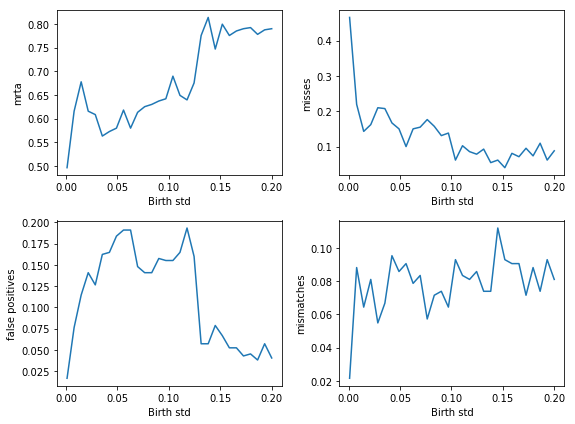

In [49]:
fig = plot_clear_metrics(birth_std_list, mota_reports, 'Birth std')